In [1]:
import sys
sys.path.append('../')
from source.interference_reject import InterferenceReject
import numpy as np
from source.reader import read_raw
from source.gridding import NFFT
import matplotlib.pyplot as plt
%matplotlib inline

## Data import

In [2]:
file_name = "../data/fse_phantom.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
num_channels_all = metadata['console']['adc']['number_channels']
num_channels_signal = metadata['rf']['receive']['num_signal_channels']
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T
print(data['scan'].shape)

(3120, 16, 134)


## Interference rejection

In [3]:

rej_prescan = InterferenceReject(
    use_prescan=True,
    channels_signal=num_channels_signal,
    channels_all=num_channels_all,
    num_freq_bins=matrix_size[0],
)
data_cor = rej_prescan.apply(scan_raw=data['scan'], prescan_raw=data['noise'])
print(data_cor.shape)

(3120, 8, 134)


## Gridding

In [4]:
spec_cor = np.fft.fftshift(np.fft.fft(data_cor, axis=-1), axes=-1)
spec_scan = np.fft.fftshift(np.fft.fft(data['scan'], axis=-1), axes=-1)
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:], n_channels=num_channels_signal)
dims_4d = np.concatenate((matrix_size, [num_channels_signal]))
img_cor = np.zeros(dims_4d, dtype=np.complex64)
img_nocor = np.zeros(dims_4d, dtype=np.complex64)
for _f in range(img_cor.shape[-1]):
    img_cor[_f, :, :] = encode_op.adjoint(spec_cor[:, :, _f])
    img_nocor[_f, :, :] = encode_op.adjoint(spec_scan[:, :8, _f])

(134, 132, 36, 8)


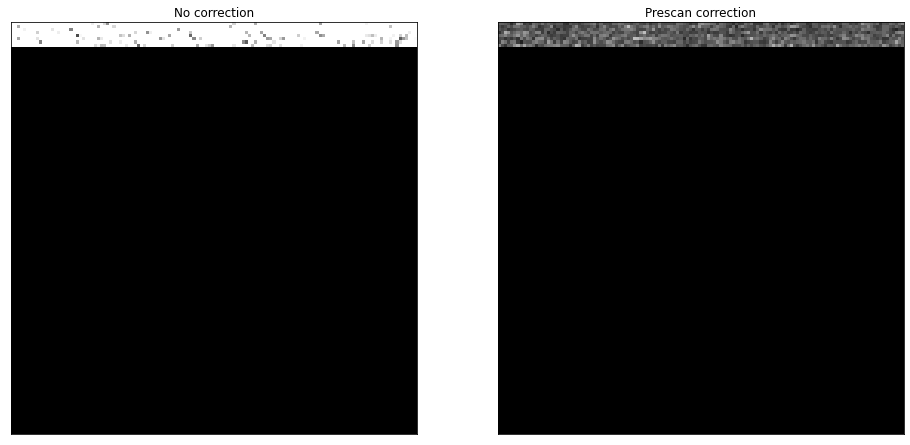

In [5]:
print(img_cor.shape)
# Plot data
sos_cor = np.sqrt(np.sum(np.abs(img_cor) ** 2, axis=-1))
sos_nocor = np.sqrt(np.sum(np.abs(img_nocor) ** 2, axis=-1))

max_I = np.max(np.abs(sos_cor))
slc = 30
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(np.abs(sos_nocor[:, :, slc]), cmap='gray', vmin=0, vmax=max_I)
plt.title("No correction")
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(np.abs(sos_cor[:, :, slc]), cmap='gray', vmin=0, vmax=max_I)
plt.title("Prescan correction")
plt.xticks([])
plt.yticks([])
plt.show()